In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from typing import Tuple, List

In [ ]:
import os
import sys
import pickle


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [ ]:
from Utils.data_utils import get_data_and_state_list

In [ ]:
def generate_dense_model(layers: List[int], output_len: int):
    
    model = tf.keras.models.Sequential()
    
    for units in layers:
        model.add(tf.keras.layers.Dense(units=units))
    
    model.add(tf.keras.layers.Dense(units=output_len*1))
    
    return model



def generate_data(df: pd.DataFrame, input_len: int, output_len: int, x_cols: List[str], y_cols: List[str], val_ratio: float):
    
    data_X = df.loc[:, x_cols].to_numpy().reshape(-1, len(x_cols))
    data_y = df.loc[:, y_cols].to_numpy().reshape(-1, len(y_cols))
    
    # maybe later :)
    # data_X = (data_X - data_X.mean(axis=0)) / data_X.std(axis=0)
    # data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)
    
    X = []
    y = []

    for i in range(input_len, data_X.shape[0]-output_len):
        inp = data_X[i-input_len:i, :]
        out = data_y[i:i+output_len, :]
        X.append(inp)
        y.append(out)

    X = np.array(X).reshape(-1, input_len, len(x_cols))
    y = np.array(y).reshape(-1, output_len, len(y_cols))
    
    val_len = int(val_ratio * X.shape[0])
    train_X = X[:-val_len, ...]
    train_y = y[:-val_len, ...]
    val_X = X[-val_len:, ...]
    val_y = y[-val_len:, ...]
    
    return (train_X, train_y), (val_X, val_y)



def plot_history(history: tf.keras.callbacks.History):
    f, ax = plt.subplots(2, 1, figsize=(16,8))
    ax[0].plot(history.history["loss"], label="train")
    ax[0].plot(history.history["val_loss"], label="val")
    ax[0].set_title("MSE Loss")
    ax[0].legend()
    ax[1].plot(history.history["mean_absolute_error"], label="train")
    ax[1].plot(history.history["val_mean_absolute_error"], label="val")
    ax[1].set_title("MAE Loss")
    ax[1].legend()
    plt.show()



def compile_and_fit(model: tf.keras.Model, X: np.ndarray, y: np.ndarray, val: Tuple[np.ndarray], max_epochs: int = 20, patience: int = 2, verbose: int = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    history = model.fit(X, y, epochs=max_epochs, batch_size=4, validation_data=val, callbacks=[early_stopping], verbose=verbose)
    
    return history



def fit_dense(input_len: int, output_len: int, layers: List[int],
             df: pd.DataFrame, x_cols: List[str] = ..., y_cols: List[str] = ..., val_ratio: float = 0.2,
             max_epochs: int = 20, patience: int = 2, verbose: int = 0):
    
    if x_cols is Ellipsis:
        x_cols = ["carbon_per_MWh", "day_sin", "day_cos", "year_sin", "year_cos"]
    if y_cols is Ellipsis:
        y_cols = ["carbon_per_MWh"]
    
    dense = generate_dense_model(layers=layers, output_len=output_len)
    
    (X, y), (val_X, val_y) = generate_data(df=df, input_len=input_len, output_len=output_len, x_cols=x_cols, y_cols=y_cols, val_ratio=val_ratio)
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    val_X = val_X.reshape(val_X.shape[0], -1)
    val_y = val_y.reshape(val_y.shape[0], -1)
    print([a.shape for a in (X, y, val_X, val_y)])

    history = compile_and_fit(model=dense, X=X, y=y, val=(val_X, val_y), max_epochs=max_epochs, patience=patience, verbose=verbose)
    plot_history(history=history)
    
    return_obj = {
        "model": dense,
        "history": history,
        "hp": {
            "input_len": input_len,
            "output_len": output_len,
            "layers": layers,
            "x_cols": x_cols,
            "y_cols": y_cols,
            "val_ratio": val_ratio,
            "max_epochs": max_epochs,
            "patience": patience
        }
    }
    
    return return_obj

In [ ]:
df_list, state_list = get_data_and_state_list(pwd="..")

In [ ]:
# settings

day_hours = 24 * 60 * 60
year_hours = 365.2425 * day_hours

input_len = 7 * 24
output_len = 24
layers = [256, 64, 32]
max_epochs = 50
patience = 5


# getting predictions

preds_list = []

for df, state in zip(df_list, state_list):
    
    print(f"\n\n==== {state} ====")
    
    # dataframe preparation
    
    df.datetime = pd.to_datetime(df.datetime)
    timestamp_s = df.datetime.map(dt.datetime.timestamp)

    df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day_hours))
    df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day_hours))
    df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year_hours))
    df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year_hours))

    df = df.fillna(value=0)

    df_train = df.loc[df.datetime.dt.year < 2022]


    # training model

    week2day = fit_dense(input_len=input_len, output_len=output_len, layers=layers, df=df_train, max_epochs=max_epochs, patience=patience, verbose=1)


    # generating predictions
    
    model = week2day["model"]
    hp = week2day["hp"]
    input_len = hp["input_len"]
    output_len = hp["output_len"]
    x_cols = hp["x_cols"]
    y_cols = hp["y_cols"]

    df_test = df.loc[(df.datetime + dt.timedelta(hours=hp["input_len"])).dt.year >= 2022]
    data_X = df_test.loc[:, x_cols].to_numpy()

    test_X = []
    for i in range(input_len, data_X.shape[0], output_len):
        inp = data_X[i-input_len:i, ...].ravel()
        test_X.append(inp)

    test_X = np.array(test_X)
    
    
    # saving predictions to dict
    
    timestamps = df.loc[df.datetime.dt.year >= 2022, "datetime"]
    preds = model.predict(test_X).ravel()
    preds_dict = {t: p for t, p in zip(timestamps, preds)}
    
    preds_list.append(preds_dict)

In [ ]:
with open("../data/predictions/dnn_pred_usa.pkl", "wb") as f:
    pickle.dump(preds_list, f)

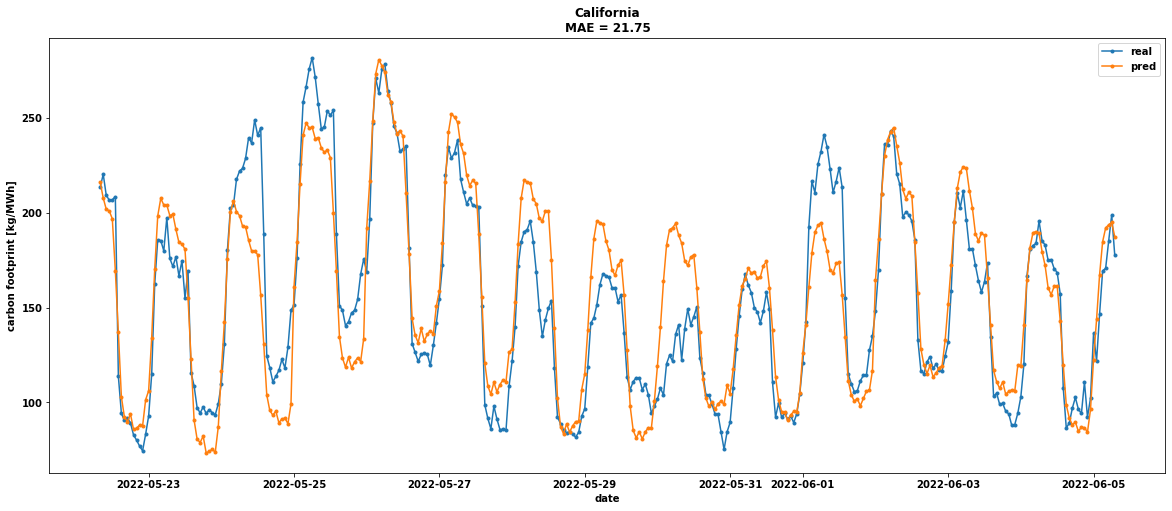

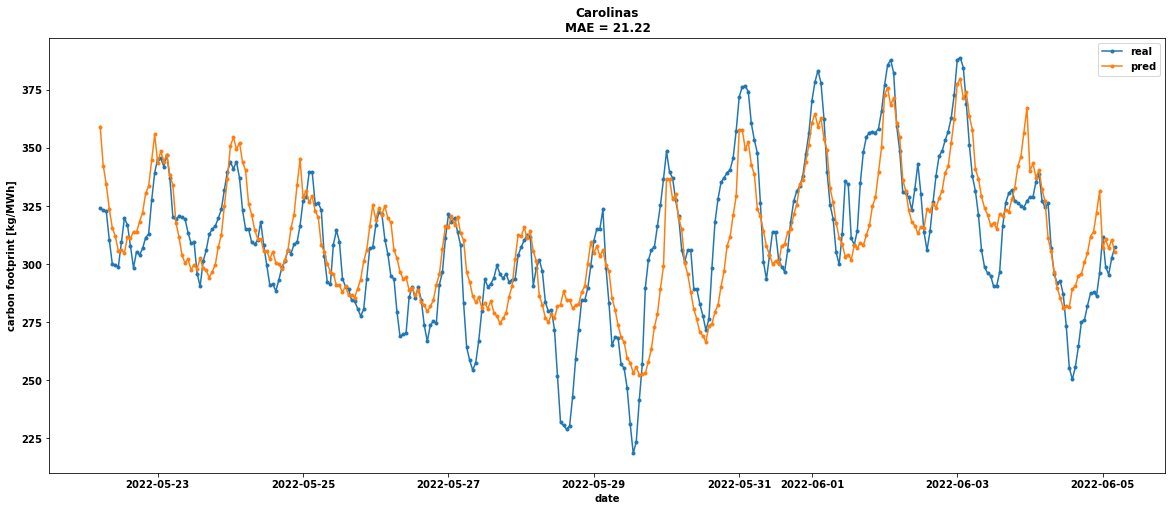

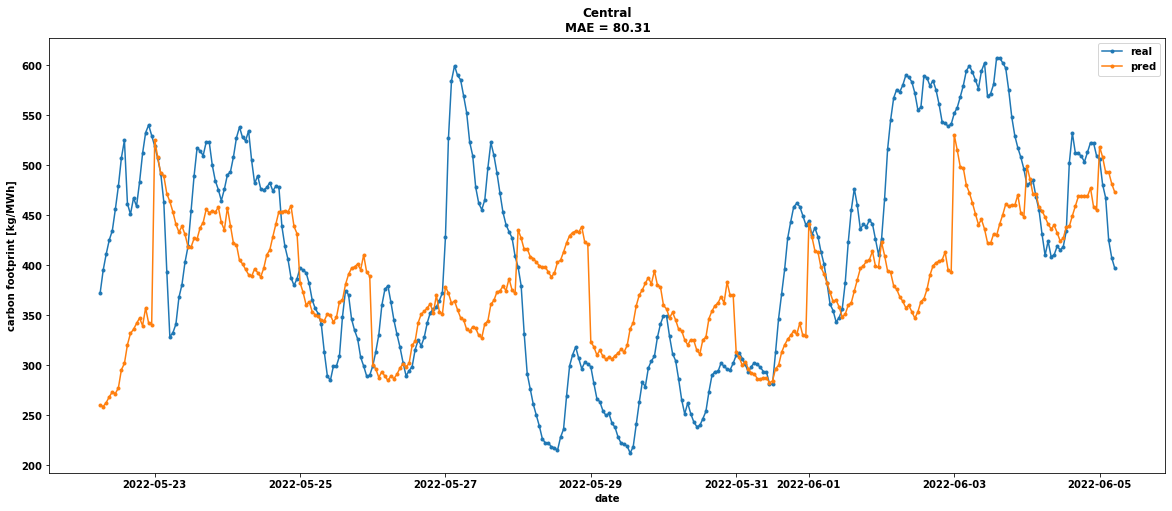

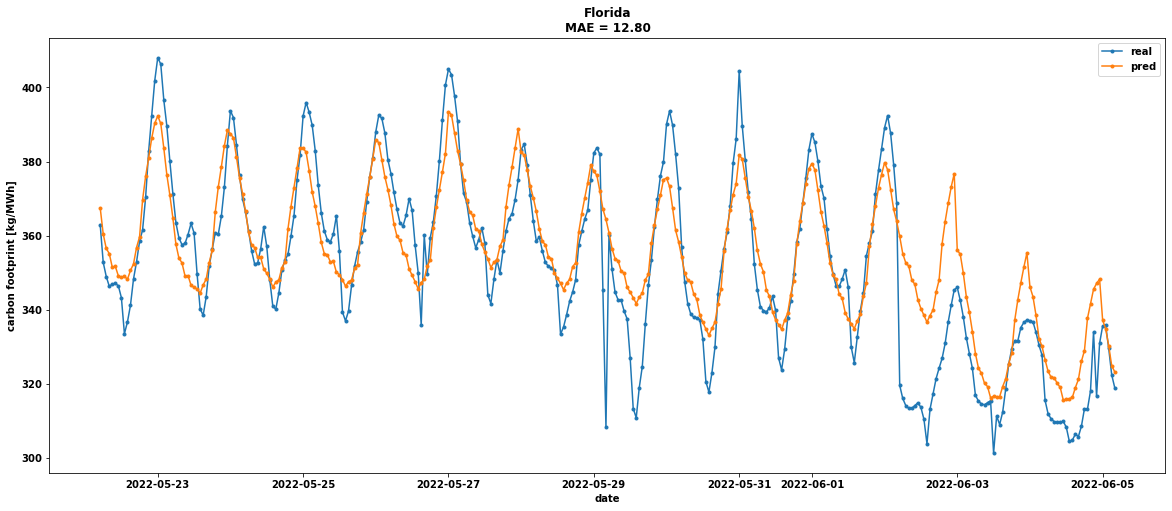

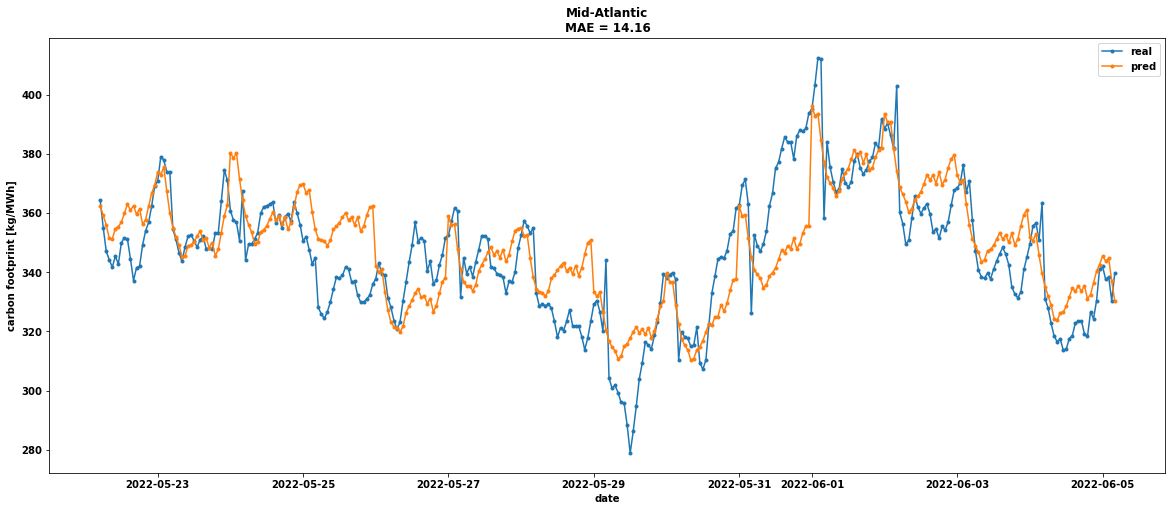

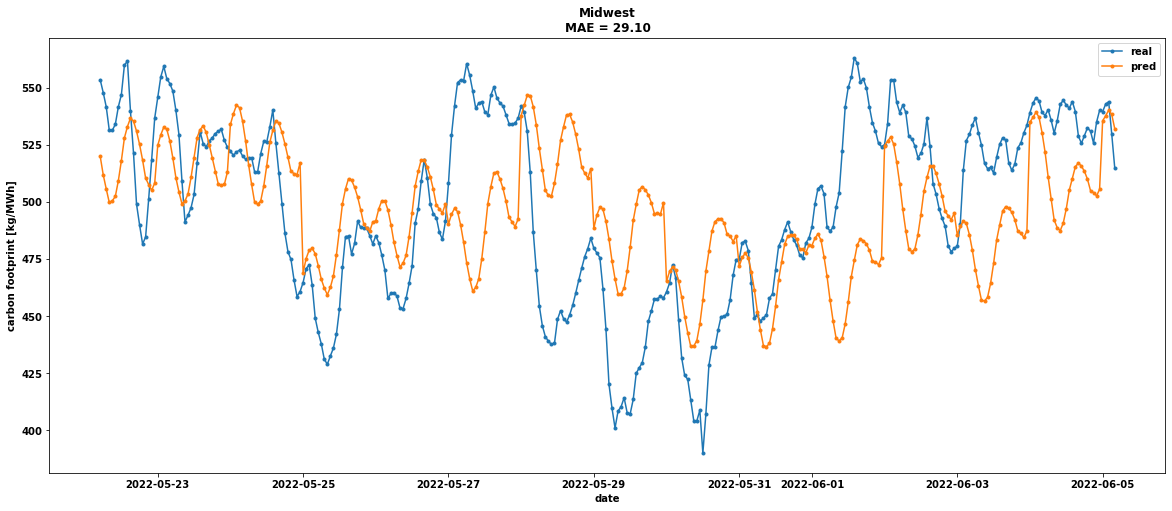

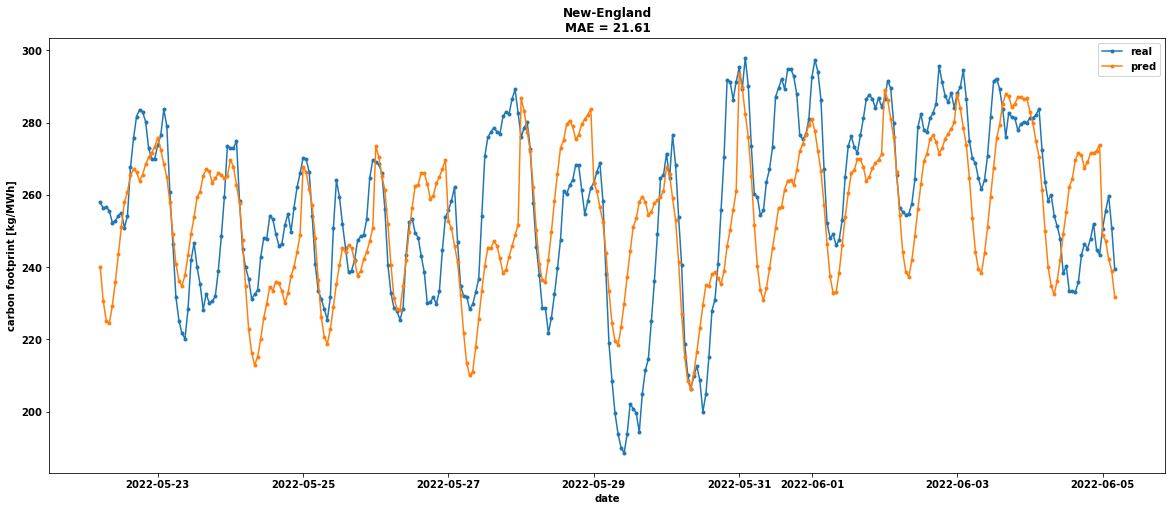

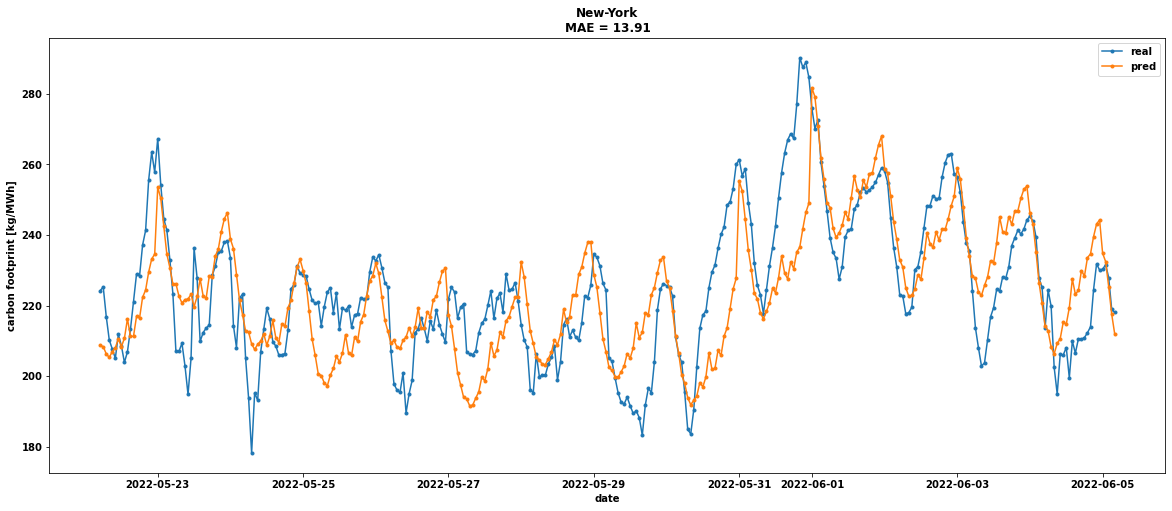

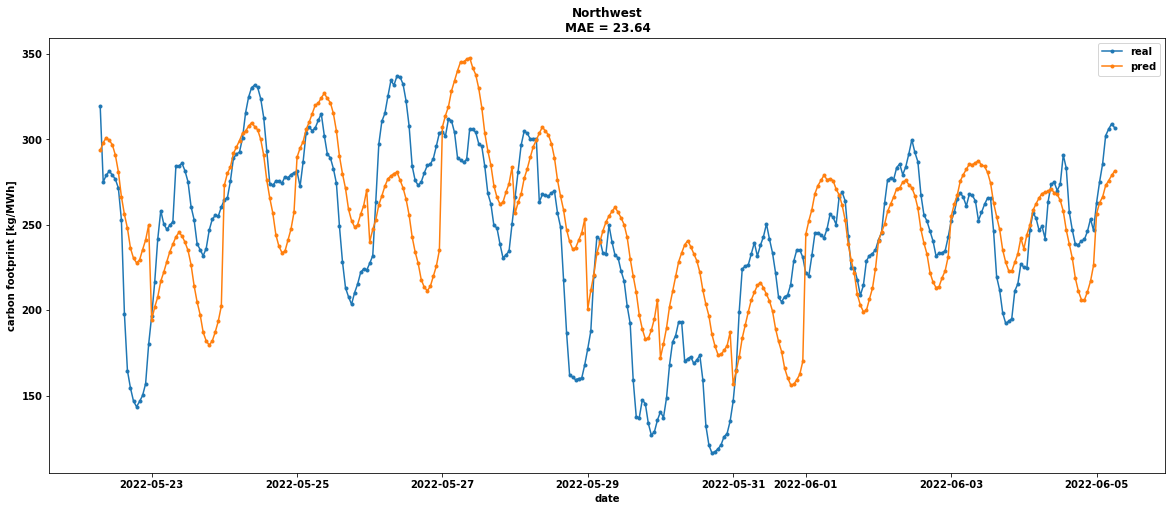

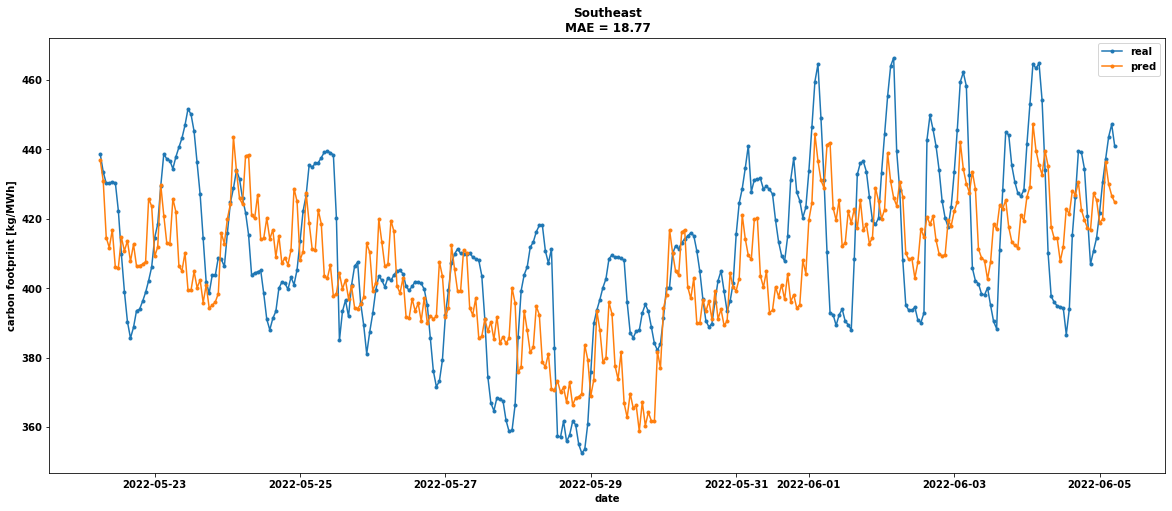

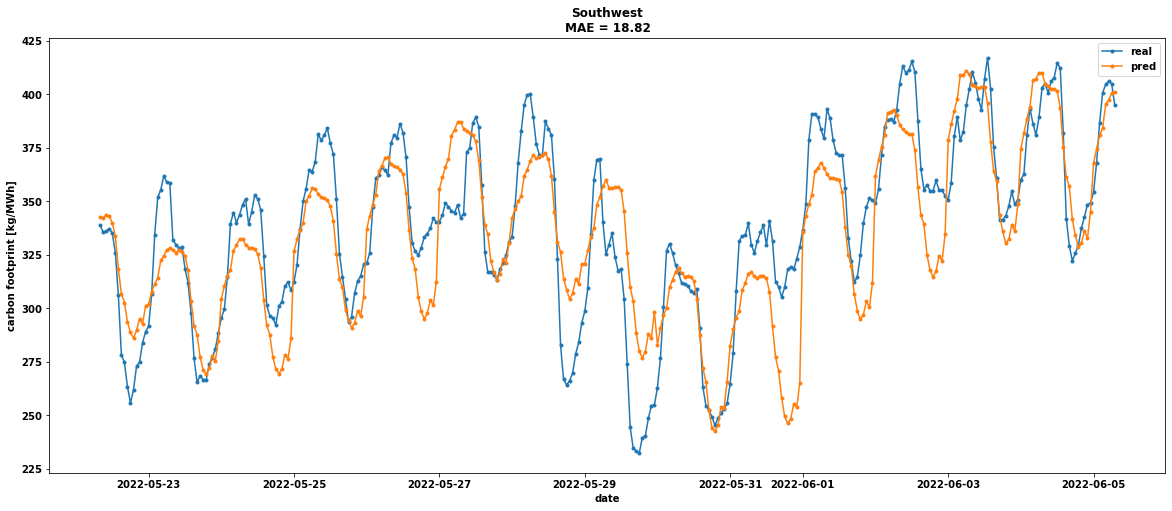

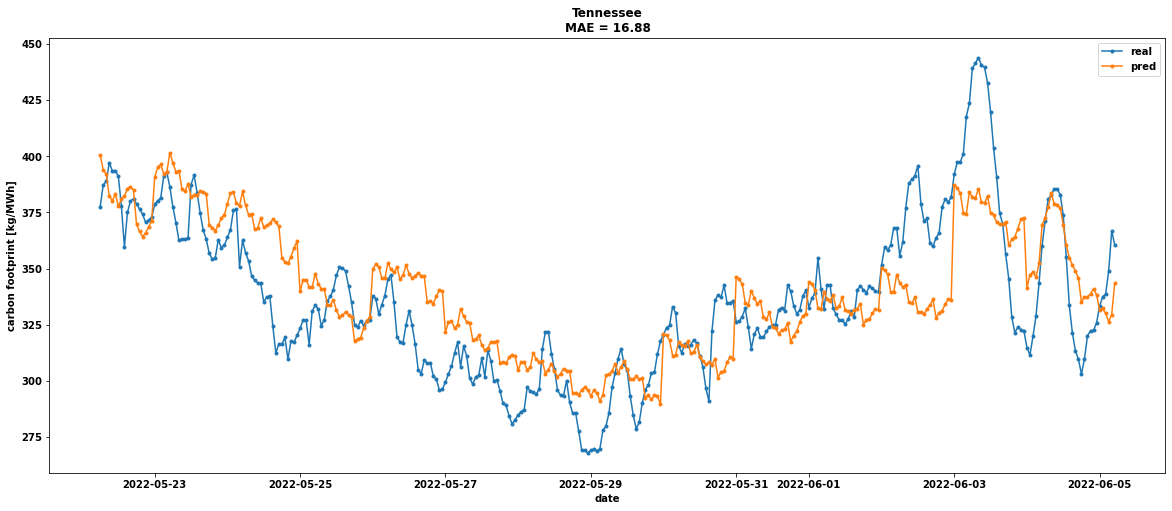

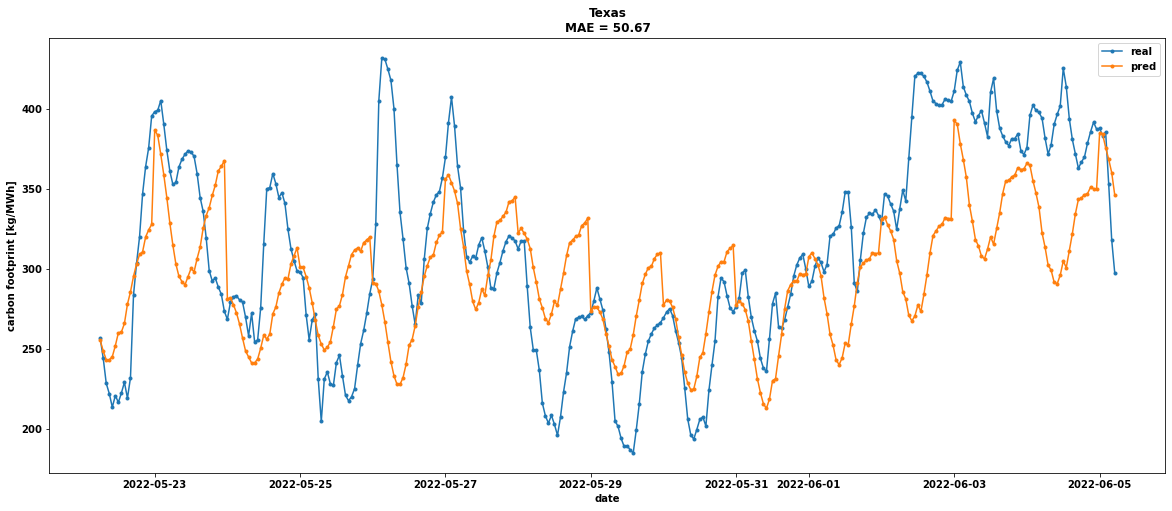

In [ ]:
for state, df, pred_dict in zip(state_list, df_list, preds_list):
    
    x = list(pred_dict.keys())
    preds = list(pred_dict.values())
    real = df.loc[df.datetime.dt.year >= 2022, "carbon_per_MWh"].to_numpy()
    
    mae = np.mean(np.abs(real-preds))
    
    n = 14*24
    x, preds, real = x[-n:], preds[-n:], real[-n:]
    
    f = plt.figure(figsize=(20,8))
    plt.plot(x, real, '.-', label="real")
    plt.plot(x, preds, '.-', label="pred")
    plt.title(f"{state}\nMAE = {mae:.2f}")
    plt.xlabel("date")
    plt.ylabel("carbon footprint [kg/MWh]")
    plt.legend()
    plt.show()